In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import matplotlib.pyplot as plt
import random

In [24]:
class Actor(nn.Module):
    def __init__(self, input_dims, output_dims, lr):
        super(Actor, self).__init__()

        self.checkpoint = 'actor.pth'

        self.actor = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dims),
            nn.Softmax(dim=-1)
        )

        self.optimiser = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        return Categorical(dist)

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint)
        
class Critic(nn.Module):
    def __init__(self, input_dims, lr):
        super(Critic, self).__init__()
        self.checkpoint = 'critic.pth'

        self.critic = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.optimiser = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device=self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint)

In [34]:
class Agent:
    def __init__(self, input_dims, output_dims, actor_lr=0.001,critic_lr =0.002, gamma=0.99, gae_lambda=0.95, policy_clip=1.1, batch_size=10,
                 memory_size=50, n_epochs=5):
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.policy_clip = policy_clip
        self.batch_size = batch_size
        self.memory_size = memory_size
        self.n_epochs = n_epochs

        self.actor = Actor(input_dims=input_dims, output_dims=output_dims, lr=actor_lr)
        self.critic = Critic(input_dims=input_dims, lr=critic_lr)

        self.states = []
        self.actions = []
        self.rewards = []
        self.probs = []
        self.values = []
        self.dones = []

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.probs = []
        self.values = []
        self.dones = []
        self.rewards = []

    def remember(self, state, action, reward, prob, value, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.probs.append(prob)
        self.values.append(value)
        self.dones.append(done)

    def save(self):
        print("Saving model...")
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def choose_action(self, state):
        state = torch.Tensor(np.array(state)).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)

        action = dist.sample()
        prob = dist.log_prob(action).item()
        value = value.item()
        action = action.item()

        return action, value, prob

    def ppo_iter(self, advantages):

        self.states = np.array(self.states)
        self.actions = np.array(self.actions)
        self.probs = np.array(self.probs)
        self.values = np.array(self.values)
        advantages = np.array(advantages)

        for _ in range(self.memory_size // self.batch_size):
            random_indices = np.random.randint(0, self.memory_size, self.batch_size)
            yield self.states[random_indices], self.actions[random_indices], self.values[random_indices], self.probs[
                random_indices], advantages[random_indices]

    def learn(self):

        advantages = np.zeros(len(self.rewards), dtype=np.float32)

        for t in range(len(self.rewards) - 1):
            discount = 1
            a_t = 0
            for k in range(t, len(self.rewards) - 1):
                a_t += discount * (self.rewards[k] + self.gamma * self.values[k + 1] * (1 - self.dones[k]) - self.values[k])
                discount *= self.gamma * self.gae_lambda
                if self.dones[k]:
                    break
            advantages[t] = a_t

        for _ in range(self.n_epochs):

            for state, action, value, prob, advantage in self.ppo_iter(advantages):
                state = torch.tensor(np.array(state)).to(self.actor.device)
                action = torch.tensor(np.array(action)).to(self.actor.device)
                prob = torch.tensor(np.array(prob)).to(self.actor.device)
                value = torch.tensor(np.array(value)).to(self.actor.device)
                advantage = torch.tensor(np.array(advantage)).to(self.actor.device)

                dist = self.actor(state)
                critic_values = self.critic(state)
                new_probs = dist.log_prob(action)

                prob_ratio = new_probs.exp() / prob.exp()

                weighted_probs = prob_ratio * advantage
                weighted_clipped_probs = torch.clamp(prob_ratio, 1 - self.policy_clip, 1 + self.policy_clip) * advantage

                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage + value
                critic_loss = ((returns - critic_values) ** 2).mean()

                total_loss = 0.5 * critic_loss + actor_loss

                self.actor.zero_grad()
                self.critic.zero_grad()
                total_loss.backward()
                self.actor.optimiser.step()
                self.critic.optimiser.step()
        self.clear_memory()

In [35]:
def run_episodes(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        action = policy.decide(observation) if hasattr(policy, 'decide') else policy(env, observation)

        observation, reward, done, _ = env.step(action)
    return frames

Saving model...
Episode: 1 score: -174.90165587357782 avg score  -174.90165587357782
Episode: 2 score: -193.36188071610695 avg score  -184.1317682948424
Saving model...
Episode: 3 score: -107.72915695697397 avg score  -158.6642311822196
Episode: 4 score: -193.09788594096858 avg score  -167.27264487190683
Episode: 5 score: -158.8016444651555 avg score  -165.57844479055657
Saving model...
Episode: 6 score: -74.09147116021207 avg score  -150.33061585216583
Saving model...
Episode: 7 score: -129.4773769095289 avg score  -147.35158171750342
Saving model...
Episode: 8 score: -63.157905836146014 avg score  -136.82737223233374
Episode: 9 score: -184.87680307263062 avg score  -142.1661978812556
Saving model...
Episode: 10 score: 12.371479123833623 avg score  -126.7124301807467
Episode: 11 score: -186.87484466638801 avg score  -132.18174058853228
Saving model...
Episode: 12 score: -61.33841130030116 avg score  -126.27812981451302
Saving model...
Episode: 13 score: -67.77140686384624 avg score  -

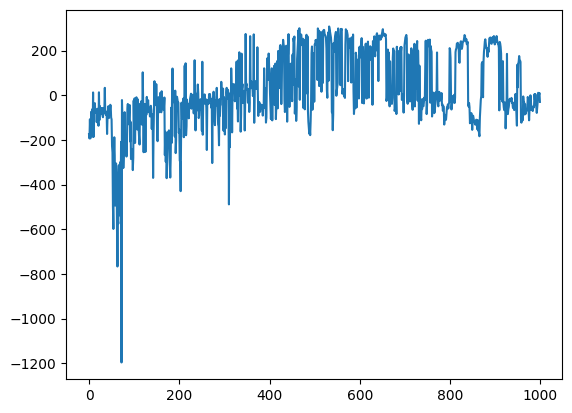

In [36]:
env = gym.make("LunarLander-v3")
env.reset()
EPISODES = 1000
BATCH_SIZE = 30
MEMORY_SIZE = 150
agent = Agent(input_dims=env.observation_space.shape[0], output_dims=env.action_space.n, actor_lr=0.0001, 
              critic_lr=0.0003,
              batch_size=BATCH_SIZE,
              memory_size=MEMORY_SIZE, n_epochs=5)

scheduler1 = ExponentialLR(agent.actor.optimiser, gamma=0.99)
scheduler2 = ExponentialLR(agent.critic.optimiser, gamma=0.99)

best_score = float('-inf')
score_history = []
n_steps = 0
avg_score = 0
for episode in range(1, EPISODES + 1):
    state = env.reset(seed=0)[0]
    done = False
    score = 0
    while not done:
        n_steps += 1

        action, value, prob = agent.choose_action(state)
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        score += reward

        agent.remember(state, action, reward, prob, value, done)

        if n_steps % MEMORY_SIZE == 0:
            _, value, _ = agent.choose_action(new_state)
            agent.values.append(value)
            agent.learn()

        state = new_state

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save()

    print(
        f'Episode: {episode} score: {score} avg score  {avg_score}')

plt.plot([i for i in range(len(score_history))], score_history)
plt.show(block=True)